In [1]:
from utils import *

import lsqfit
import gvar as gv

import os
import platform
import h5py
import numpy as np
import matplotlib.pyplot as plt

userDir=os.path.expanduser('~')
baseDir=os.path.join(userDir,'Documents','LatticeQCD','PIPI')

beta=4.03
mh=0.2
ncStep=5
NT=64

# TODO: normalize correlator

In [2]:
def get_avg_pion_corr_folded(sourceTimes):
    pionCorrs=get_all_pion_source_corrs(pionDir, sourceTimes, ncStart, ncFinish, ncStep)

    avgPionCorr=pionCorrs[sourceTimes[0]]
    for t0 in sourceTimes[1:]:
        avgPionCorr+=pionCorrs[t0]
    avgPionCorr=avgPionCorr/len(sourceTimes)

    avgPionCorr=np.array([foldCorr(c,NT) for c in avgPionCorr])

    return avgPionCorr


In [3]:
def multi_exp_model(t, p, Nexc=2):
    ans = 0.0
    for i in range(0, Nexc):
        ans += p["A{}".format(i)] * np.exp(-p["E{}".format(i)] * t)
    return ans

In [4]:
fitModelSingleExp = lambda t,p : multi_exp_model(t,p,1)
paramInitSingleExp = {
    "A0": 1, "E0": 0.5,
    #"A1": 0.1, "E1": 1.5,
    #"A2": 0.0001, "E2": 0.1
}

fitModelTripleExp = lambda t,p : multi_exp_model(t,p,3)
paramInitTripleExp = {
    "A0": 1, "E0": 0.5,
    "A1": 0.1, "E1": 1.5,
    "A2": 0.0001, "E2": 0.1
}

In [12]:
mls = [0.03,0.04,0.05,0.075,0.1,0.125,0.15,0.2]
mlsBestFit = {}
for ml in mls:
    mlDir=os.path.join(baseDir,'b{}_ml{}_mh{}'.format(beta,ml,mh))
    pionDir=os.path.join(mlDir,'mesons')

    ncStart, ncFinish = get_nc_start_fin(pionDir)
    NCFG = (ncFinish-ncStart)/ncStep

    sourceTimes=[i for i in range(0,64,8)]
    avgPionCorr=get_avg_pion_corr_folded(sourceTimes)

    data = {'t': np.asarray([t for t in range(int(NT/2))]), 'ND': NCFG, 'yraw': np.real(avgPionCorr[:,0:int(NT/2)])}
    data['y']=gv.dataset.avg_data(data['yraw'], bstrap=True)

    minChi2=1e10
    bestFit=None
    for ti in range(7,19):
        for tf in range(20,26):
            if tf-ti > 2:
                fitres1=lsqfit.nonlinear_fit(
                    data=(data['t'][ti:tf], data['y'][ti:tf]),
                    fcn = fitModelSingleExp, 
                    p0=paramInitSingleExp
                )

                if fitres1.chi2<minChi2:
                    minChi2=fitres1.chi2
                    bestFit=[ti,tf,fitres1]
    
    mlsBestFit[ml]=bestFit

In [20]:
e0 = lambda ml : mlsBestFit[ml][2].p['E0'].mean
e0err = lambda ml : mlsBestFit[ml][2].p['E0'].sdev

<ErrorbarContainer object of 3 artists>

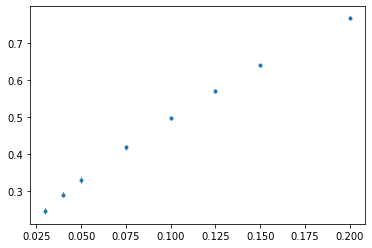

In [26]:
plt.errorbar(mls, [e0(ml) for ml in mls], yerr=[e0err(ml) for ml in mls],
    linestyle="None", marker=".", lw=1)

(0.18, 0.52)

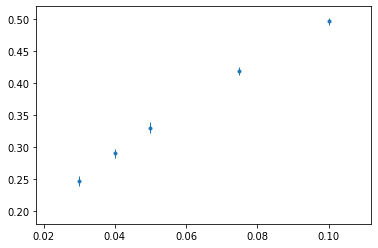

In [30]:
plt.errorbar(mls, [e0(ml) for ml in mls], yerr=[e0err(ml) for ml in mls],
    linestyle="None", marker=".", lw=1)
plt.xlim(0.018,0.112)
plt.ylim(0.18,0.52)

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


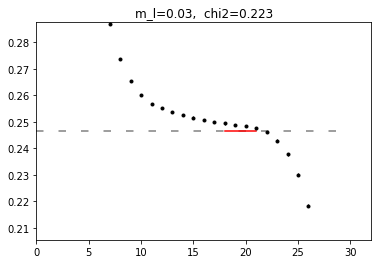

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


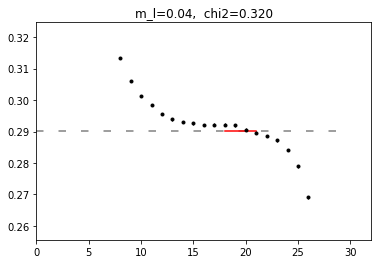

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


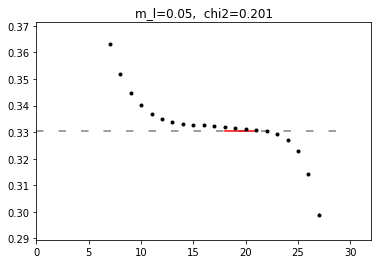

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


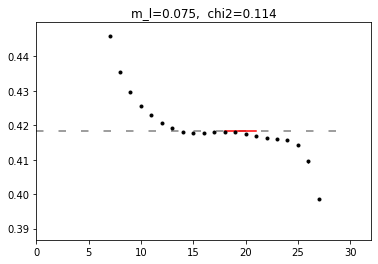

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


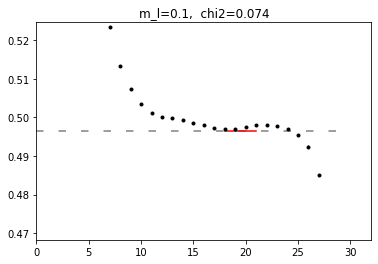

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


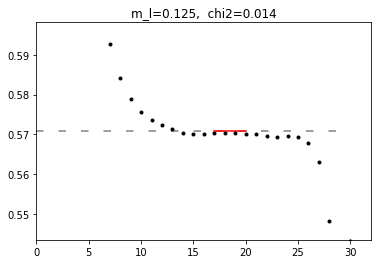

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


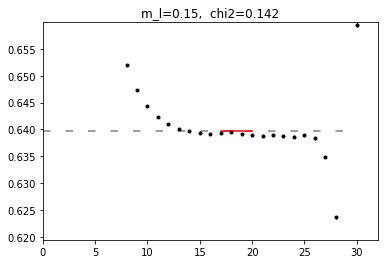

/home/chris/Code/LQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


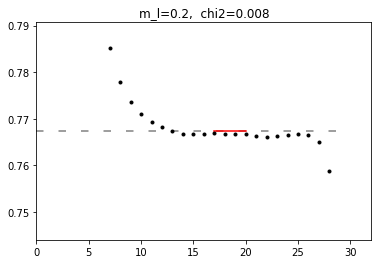

In [40]:
from jk import *
for ml in mls:
    mlDir=os.path.join(baseDir,'b{}_ml{}_mh{}'.format(beta,ml,mh))
    pionDir=os.path.join(mlDir,'mesons')

    ncStart, ncFinish = get_nc_start_fin(pionDir)
    NCFG = (ncFinish-ncStart)/ncStep

    sourceTimes=[i for i in range(0,64,8)]
    avgPionCorr=get_avg_pion_corr_folded(sourceTimes)

    effMass=jackKnife(log_effective_mass,avgPionCorr)

    plt.errorbar([t for t in range(len(effMass[0]))], effMass[0].real, yerr=effMass[1].real,
        linestyle="None", marker=".", lw=1, color="black")
    fitTi=mlsBestFit[ml][0]
    fitTf=mlsBestFit[ml][1]
    plt.plot([t for t in range(len(effMass[0]))],[e0(ml) for t in range(len(effMass[0]))],linestyle=(0,(5,10)),color="gray")
    plt.plot([t for t in range(fitTi,fitTf+1)],[e0(ml) for t in range(fitTi,fitTf+1)], color="red")
    plt.xlim(0,32)
    plt.ylim(e0(ml)-5*e0err(ml),e0(ml)+5*e0err(ml))
    plt.title("m_l={},  chi2={:0.3f}".format(ml,mlsBestFit[ml][2].chi2))
    plt.show()
    